# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement:
Build a machine learning model that predicts offers based on user information and offer event

In [2]:
%matplotlib inline

In [131]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.pipeline import Pipeline
import keras
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Cleaning

## 1. Portfolio Data

### OverView:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [46]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [47]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [48]:
for index, row in portfolio.iterrows():
    channels = row['channels']
    for channel in channels:
        if channel not in portfolio.columns:
            portfolio[channel] = 0
        portfolio.loc[index, channel] = 1

portfolio


,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [49]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
email         0
mobile        0
social        0
web           0
dtype: int64

## 2. Profile Data
### Overview
**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [50]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [51]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [52]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [53]:
profile.duplicated().sum()

0

## 3. Transcript Data
### Overview
**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [54]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [55]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [56]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [57]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [58]:
transcript.event.value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [59]:
transcript.event = transcript.event.str.replace(' ', '_')

In [60]:
transcript['offer_id'] = ""
transcript['amount'] = 0.0
transcript

,person,event,value,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,,0.0
2,e2127556f4f64592b11af22de27a7932,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,,0.0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,,0.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,,0.0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,,0.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,,0.0


In [61]:

for index, row in transcript.iterrows():
    if "offer_id" in row.value:
        transcript.loc[index, 'offer_id'] = row.value["offer_id"]
    if "offer id" in row.value:
        transcript.loc[index, 'offer_id'] = row.value["offer id"]
    if "amount" in row.value:
        transcript.loc[index, 'amount'] = row.value["amount"]
transcript[['offer_id', 'amount']]

,offer_id,amount
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
2,2906b810c7d4411798c6938adc9daaa5,0.00
3,fafdcd668e3743c1bb461111dcafc2a4,0.00
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00
...,...,...
306529,,1.59
306530,,9.53
306531,,3.61
306532,,3.53


In [62]:
transcript.drop('value', axis=1, inplace=True)

Merge all it into 1 df

In [63]:
merge_df = transcript.merge(profile, how='inner', left_on='person', right_on='id')
merge_df.drop(columns=['id'], axis=1, inplace=True)
merge_df


,person,event,time,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer_received,0,2906b810c7d4411798c6938adc9daaa5,0.00,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,None,118,20171002,NaN
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,,1.59,M,66,20180101,47000.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,,9.53,M,52,20180408,62000.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,,3.61,F,63,20130922,52000.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,,3.53,M,57,20160709,40000.0


In [64]:
merge_df = merge_df.merge(portfolio, how='left', left_on='offer_id', right_on='id')
merge_df.drop(columns=['id'], axis=1, inplace=True)
merge_df

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,2906b810c7d4411798c6938adc9daaa5,0.00,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,,1.59,M,66,20180101,47000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,,9.53,M,52,20180408,62000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,,3.61,F,63,20130922,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,,3.53,M,57,20160709,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
merge_df.loc[merge_df[merge_df.offer_id == ''].index, 'offer_id'] = np.nan

In [66]:
offer_id = merge_df[ ~merge_df.offer_id.isna() ].offer_id.unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [67]:
offer_id = dict(zip(offer_id, list(range(0,len(offer_id)))))
offer_id

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
 '2906b810c7d4411798c6938adc9daaa5': 2,
 'fafdcd668e3743c1bb461111dcafc2a4': 3,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 4,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 '3f207df678b143eea3cee63160fa8bed': 7,
 'ae264e3637204a6fb9bb56bc8210ddfd': 8,
 '5a8bc65990b245e5a138643cd4eb9837': 9}

In [68]:
merge_df.offer_id = merge_df.offer_id.map(offer_id)
merge_df.offer_id = pd.to_numeric(merge_df.offer_id)
merge_df.offer_id

0         0.0
1         1.0
2         2.0
3         3.0
4         4.0
         ... 
306529    NaN
306530    NaN
306531    NaN
306532    NaN
306533    NaN
Name: offer_id, Length: 306534, dtype: float64

In [69]:
events = merge_df.event.unique()
events = dict(zip(events, list(range(0,len(events)))))
events

{'offer_received': 0,
 'offer_viewed': 1,
 'transaction': 2,
 'offer_completed': 3}

In [70]:
merge_df.event= merge_df.event.map(events)
merge_df.event

0         0
1         0
2         0
3         0
4         0
         ..
306529    2
306530    2
306531    2
306532    2
306533    2
Name: event, Length: 306534, dtype: int64

In [71]:
merge_df

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0.00,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1.0,0.00,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,2.0,0.00,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,3.0,0.00,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4.0,0.00,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,2,714,NaN,1.59,M,66,20180101,47000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,2,714,NaN,9.53,M,52,20180408,62000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,2,714,NaN,3.61,F,63,20130922,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,2,714,NaN,3.53,M,57,20160709,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
print(f""" 
list person unique: 
      {merge_df.person.unique()}
number unique: {merge_df.person.nunique()}
""")

 
list person unique: 
      ['78afa995795e4d85b5d9ceeca43f5fef' 'a03223e636434f42ac4c3df47e8bac43'
 'e2127556f4f64592b11af22de27a7932' ... '912b9f623b9e4b4eb99b6dc919f09a93'
 '3045af4e98794a04a5542d3eac939b1f' 'da7a7c0dcfcb41a8acc7864a53cf60fb']
number unique: 17000



number unique value of person is too much, can't not change to int

In [73]:
# save data
merge_df.to_csv('data/merge_df.csv', index=False)

In [59]:
df = pd.read_csv('data/merge_df.csv')

## Exploration and Visualization Data:

In [60]:
df.describe()

,event,time,offer_id,amount,age,became_member_on,income,reward,difficulty,duration,email,mobile,social,web
count,306534.000000,306534.000000,167581.000000,306534.000000,306534.000000,3.065340e+05,272762.000000,167581.00000,167581.000000,167581.000000,167581.0,167581.000000,167581.000000,167581.000000
mean,1.423555,366.382940,4.481134,5.792023,60.909367,2.016545e+07,64337.000755,4.41991,7.850401,6.610737,1.0,0.917944,0.656996,0.806858
std,0.980266,200.326314,2.763352,21.337137,26.032030,1.190460e+04,21243.762941,3.37336,5.048944,2.136130,0.0,0.274451,0.474714,0.394765
min,0.000000,0.000000,0.000000,0.000000,18.000000,2.013073e+07,30000.000000,0.00000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,1.000000,186.000000,2.000000,0.000000,43.000000,2.016032e+07,48000.000000,2.00000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,2.000000,408.000000,4.000000,0.000000,57.000000,2.017041e+07,62000.000000,5.00000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
75%,2.000000,528.000000,7.000000,7.100000,72.000000,2.017113e+07,78000.000000,5.00000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,3.000000,714.000000,9.000000,1062.280000,118.000000,2.018073e+07,120000.000000,10.00000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


### Age

Text(0.5, 1.0, 'distribution of "age"')

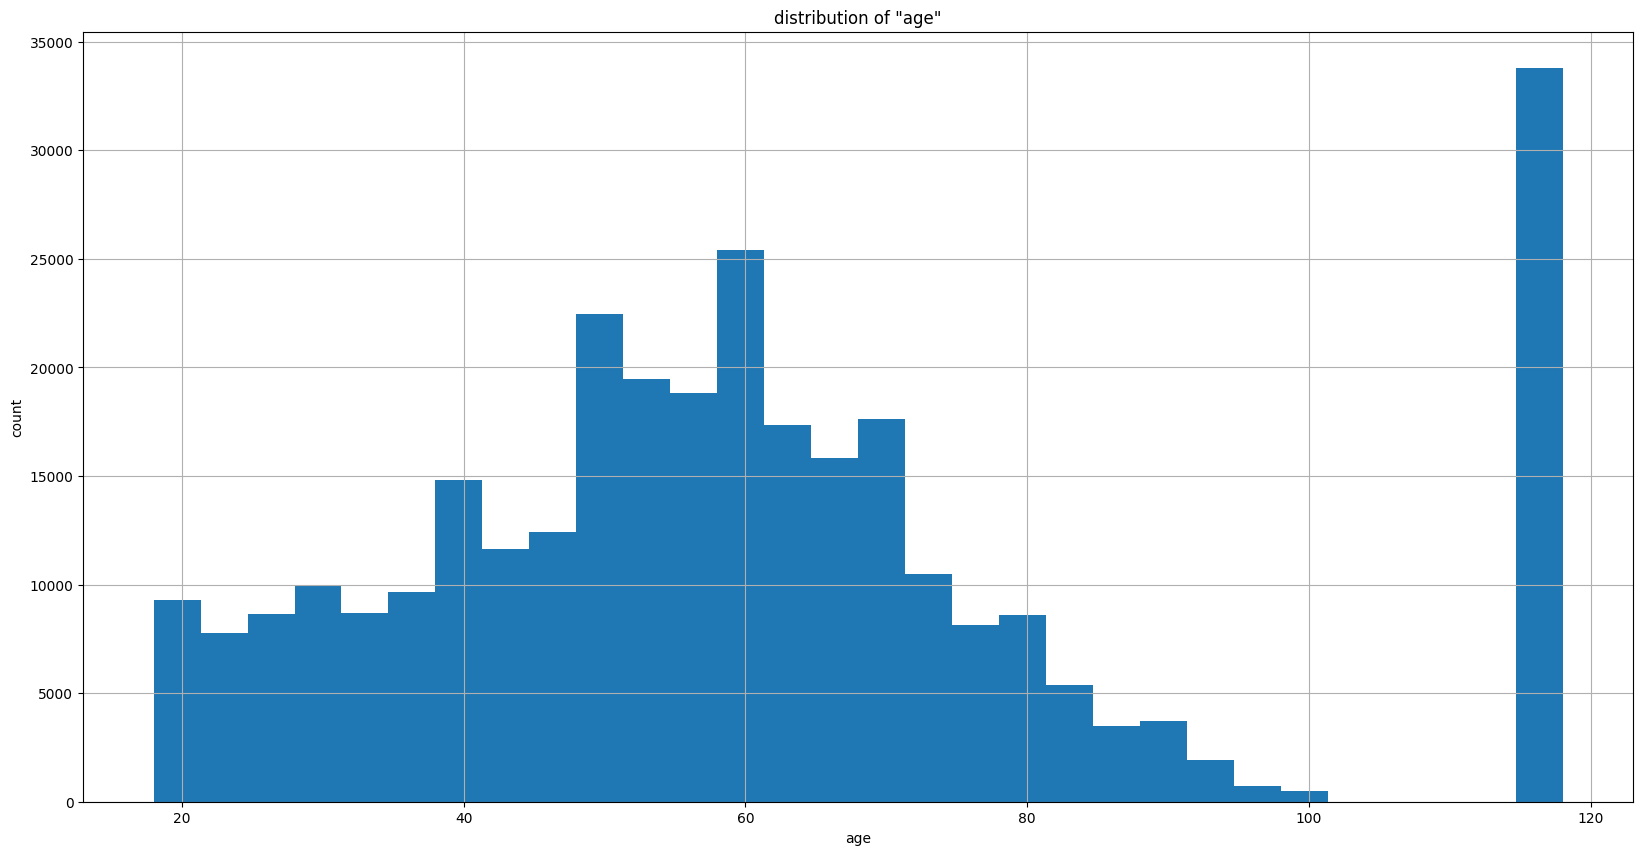

In [61]:
df.age.hist(bins=30, figsize=(20,10))
plt.xlabel("age")
plt.ylabel('count')
plt.title('distribution of "age"')

- The number of elderly people (>115 years old) is unusually large.
- Average age is 60 years old

In [62]:
# remove preson > 115 years old
df = df[df['age'] < 115]
df.age.describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'distribution of "age"')

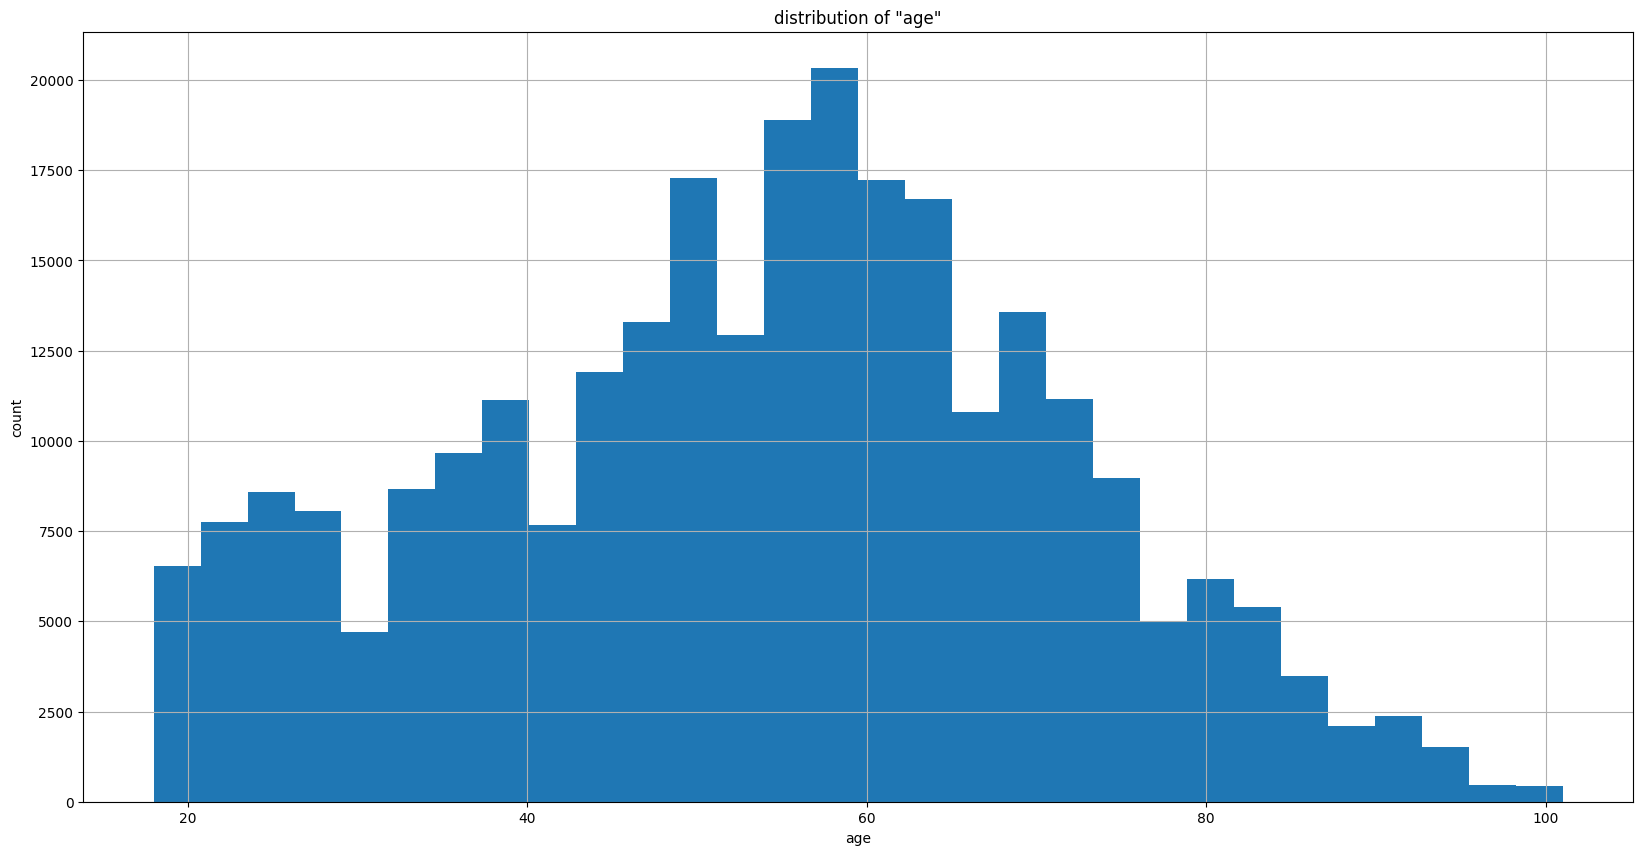

In [63]:
df.age.hist(bins=30, figsize=(20,10))
plt.xlabel("age")
plt.ylabel('count')
plt.title('distribution of "age"')

### Amount

In [64]:
df[df.amount>0.0].amount.describe()

count    123957.000000
mean         13.996325
std          31.749420
min           0.050000
25%           3.660000
50%          10.800000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

Text(0.5, 1.0, 'distribution of "amount of offer < 100"')

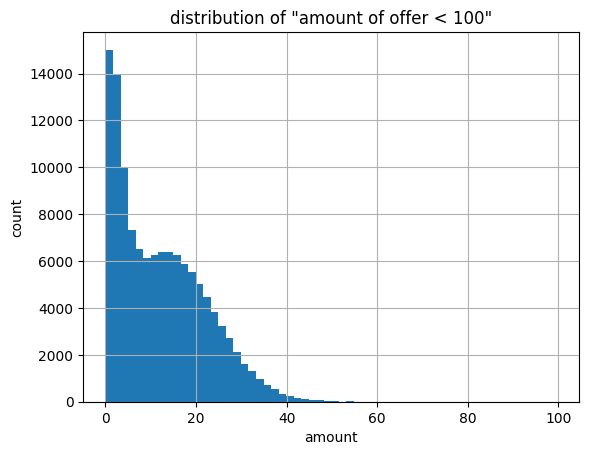

In [65]:
df[(df.amount>0.0)
   & (df.amount<=100.0)
   ].amount.hist(bins=(60))
plt.xlabel('amount')
plt.ylabel('count')
plt.title('distribution of "amount of offer < 100"')

Text(0.5, 1.0, 'distribution of "amount of offer>= 100"')

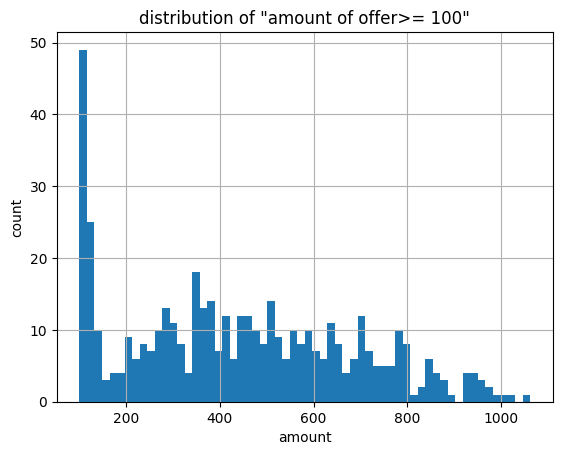

In [66]:
df[df.amount>100].amount.hist(bins=(60))
plt.xlabel('amount')
plt.ylabel('count')
plt.title('distribution of "amount of offer>= 100"')

most 'amount' < 60

In [67]:
df.gender.fillna("O", inplace=True)
df.gender

C:\Users\Max\AppData\Local\Temp\ipykernel_6656\2267702980.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.gender.fillna("O", inplace=True)


0         F
2         M
5         M
7         M
8         F
         ..
306527    F
306529    M
306530    M
306531    F
306532    M
Name: gender, Length: 272762, dtype: object

### Gender

<Axes: >

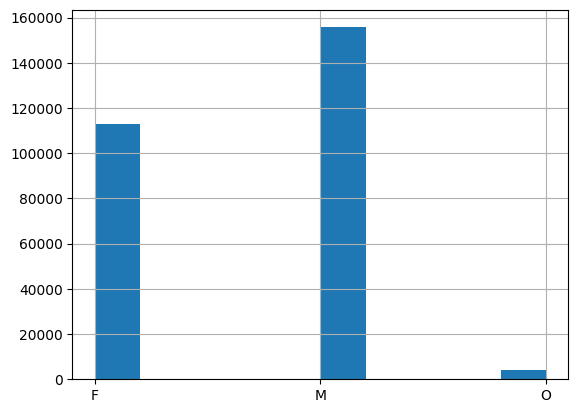

In [68]:
df.gender.hist()

Most users are male

### Income

Text(0.5, 1.0, 'distribution of "income"')

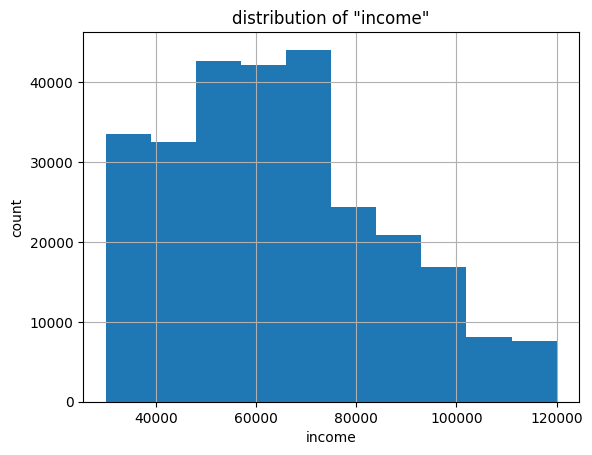

In [69]:
df.income.hist()
plt.xlabel('income')
plt.ylabel('count')
plt.title('distribution of "income"')

### Event

{
    'offer_received': 0,
    'offer_viewed': 1,
    'transaction': 2,
    'offer_completed': 3
}

Text(0, 0.5, 'count')

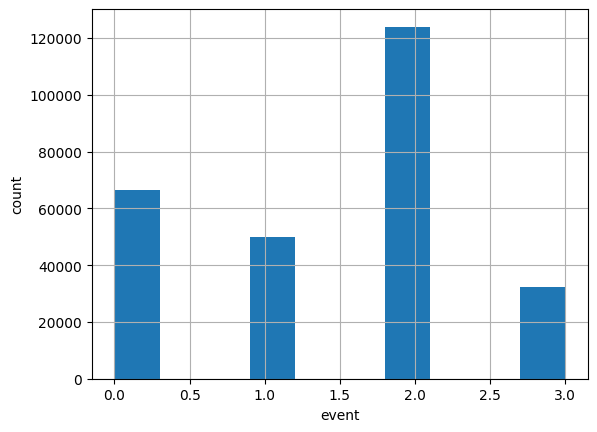

In [70]:
df.event.hist()
plt.xlabel('event')
plt.ylabel('count')

There are a lot of transactions but very few completed offers.

### Offer type

Text(0, 0.5, 'count')

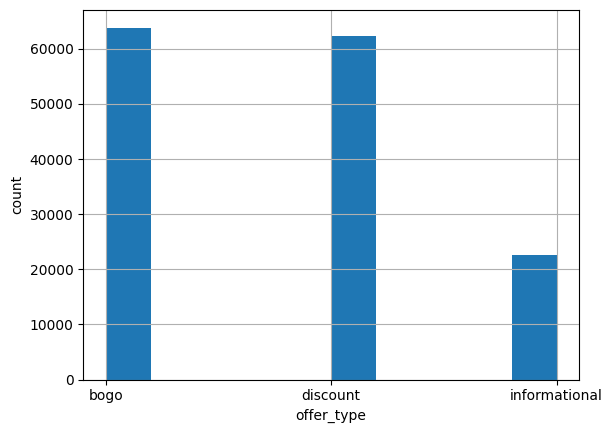

In [71]:
df.offer_type.hist()
plt.xlabel('offer_type')
plt.ylabel('count')

### Offer type & event

In [72]:
df_offer_received = df[df.event == 0]
df_offer_viewed = df[df.event == 1]
df_transaction = df[df.event == 2]
df_offer_completed = df[df.event == 3]

Text(0, 0.5, 'count')

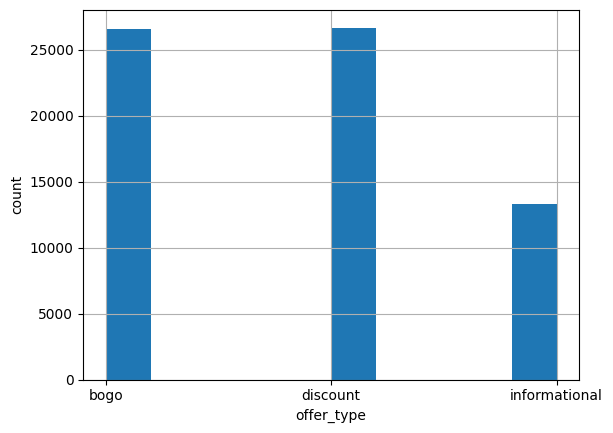

In [73]:
df_offer_received.offer_type.hist()
plt.xlabel('offer_type')
plt.ylabel('count')

Text(0, 0.5, 'count')

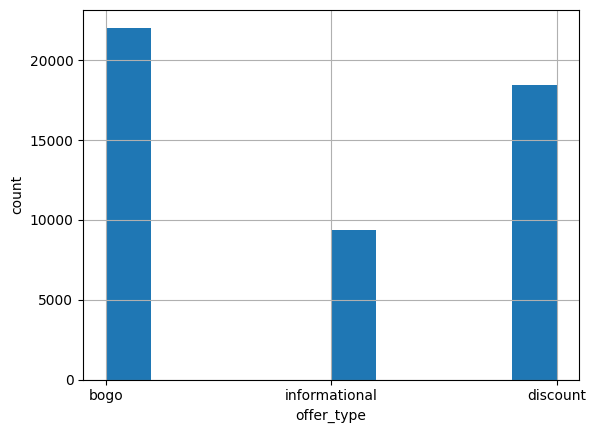

In [74]:
df_offer_viewed.offer_type.hist()
plt.xlabel('offer_type')
plt.ylabel('count')

Text(0, 0.5, 'count')

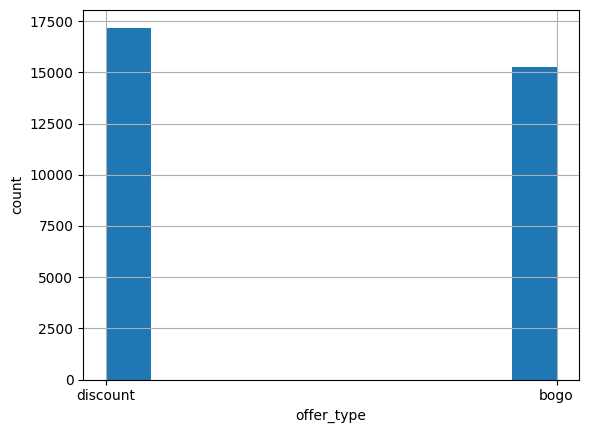

In [75]:
df_offer_completed.offer_type.hist()
plt.xlabel('offer_type')
plt.ylabel('count')

No offers of the informational type were completed.

### Offer id

In [76]:
df_offer_id = df[df.offer_id.notna()]

Text(0, 0.5, 'count')

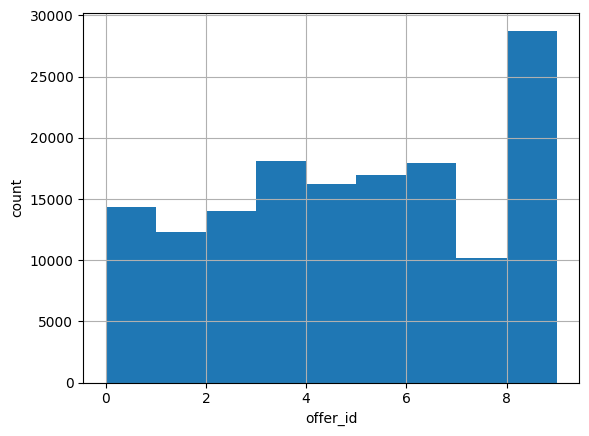

In [77]:
bin_edges = list(range(0,10,1))
df_offer_id.offer_id.astype(int).hist(bins=bin_edges)
plt.xlabel('offer_id')
plt.ylabel('count')

# Modeling and Predictions:

In [81]:
df = pd.read_csv('data/merge_df.csv')
df = df[df.offer_id.notna()]
df

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0.0,F,75,20170509,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1.0,0.0,NaN,118,20170804,NaN,5.0,"['web', 'email']",20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,2.0,0.0,M,68,20180426,70000.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,3.0,0.0,NaN,118,20170925,NaN,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4.0,0.0,NaN,118,20171002,NaN,10.0,"['web', 'email', 'mobile', 'social']",10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,3,714,6.0,0.0,NaN,118,20170116,NaN,3.0,"['web', 'email', 'mobile', 'social']",7.0,7.0,discount,1.0,1.0,1.0,1.0
306506,b895c57e8cd047a8872ce02aa54759d6,3,714,3.0,0.0,NaN,118,20170125,NaN,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,discount,1.0,1.0,1.0,1.0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,1,714,1.0,0.0,F,60,20170908,64000.0,5.0,"['web', 'email']",20.0,10.0,discount,1.0,0.0,0.0,1.0
306509,8431c16f8e1d440880db371a68f82dd0,3,714,3.0,0.0,M,39,20180627,39000.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,discount,1.0,1.0,1.0,1.0


In [82]:
df.gender.fillna('O', inplace=True)

C:\Users\Max\AppData\Local\Temp\ipykernel_3164\1471723247.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.gender.fillna('O', inplace=True)


In [83]:
genders = df.gender.unique()
genders = dict(zip(genders, list(range(0,len(genders)))))
genders

{'F': 0, 'O': 1, 'M': 2}

In [84]:
df.gender = df.gender.map(genders)

In [85]:
offer_types = df.offer_type.unique()
offer_types = dict(zip(offer_types, list(range(0,len(offer_types)))))
offer_types

{'bogo': 0, 'discount': 1, 'informational': 2}

In [86]:
df.offer_type = df.offer_type.map(offer_types)

In [87]:
df

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0.0,0,75,20170509,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,0,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1.0,0.0,1,118,20170804,NaN,5.0,"['web', 'email']",20.0,10.0,1,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,2.0,0.0,2,68,20180426,70000.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,1,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,3.0,0.0,1,118,20170925,NaN,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,1,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4.0,0.0,1,118,20171002,NaN,10.0,"['web', 'email', 'mobile', 'social']",10.0,5.0,0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,3,714,6.0,0.0,1,118,20170116,NaN,3.0,"['web', 'email', 'mobile', 'social']",7.0,7.0,1,1.0,1.0,1.0,1.0
306506,b895c57e8cd047a8872ce02aa54759d6,3,714,3.0,0.0,1,118,20170125,NaN,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,1,1.0,1.0,1.0,1.0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,1,714,1.0,0.0,0,60,20170908,64000.0,5.0,"['web', 'email']",20.0,10.0,1,1.0,0.0,0.0,1.0
306509,8431c16f8e1d440880db371a68f82dd0,3,714,3.0,0.0,2,39,20180627,39000.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,1,1.0,1.0,1.0,1.0


In [88]:
df.columns

Index(['person', 'event', 'time', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [89]:
df_obj= df.copy()

In [90]:
list_offer_id = df_obj[df_obj.offer_id.notna()].offer_id.astype(int).sort_values().unique()
list_offer_id

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [91]:
df_obj[list_offer_id] = 0
df_obj[list_offer_id]

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
306497,0,0,0,0,0,0,0,0,0,0
306506,0,0,0,0,0,0,0,0,0,0
306507,0,0,0,0,0,0,0,0,0,0
306509,0,0,0,0,0,0,0,0,0,0


In [92]:
for index, row in df_obj.iterrows():
    try:
        df_obj.loc[index, row.offer_id] += 1
    except Exception as e:
        print(f"row error {index}, error {e}")


In [93]:
df_obj[list_offer_id]

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
306497,0,0,0,0,0,0,1,0,0,0
306506,0,0,0,1,0,0,0,0,0,0
306507,0,1,0,0,0,0,0,0,0,0
306509,0,0,0,1,0,0,0,0,0,0


In [94]:
df_obj=df_obj[df_obj.offer_id.notnull()]
df_obj

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,...,0,1,2,3,4,5,6,7,8,9
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0.0,0,75,20170509,100000.0,5.0,...,1,0,0,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1.0,0.0,1,118,20170804,NaN,5.0,...,0,1,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,2.0,0.0,2,68,20180426,70000.0,2.0,...,0,0,1,0,0,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,3.0,0.0,1,118,20170925,NaN,2.0,...,0,0,0,1,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4.0,0.0,1,118,20171002,NaN,10.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,3,714,6.0,0.0,1,118,20170116,NaN,3.0,...,0,0,0,0,0,0,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,3,714,3.0,0.0,1,118,20170125,NaN,2.0,...,0,0,0,1,0,0,0,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,1,714,1.0,0.0,0,60,20170908,64000.0,5.0,...,0,1,0,0,0,0,0,0,0,0
306509,8431c16f8e1d440880db371a68f82dd0,3,714,3.0,0.0,2,39,20180627,39000.0,2.0,...,0,0,0,1,0,0,0,0,0,0


In [95]:
df_obj.fillna(0, inplace=True)
df_obj

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,...,0,1,2,3,4,5,6,7,8,9
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0.0,0,75,20170509,100000.0,5.0,...,1,0,0,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1.0,0.0,1,118,20170804,0.0,5.0,...,0,1,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,2.0,0.0,2,68,20180426,70000.0,2.0,...,0,0,1,0,0,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,3.0,0.0,1,118,20170925,0.0,2.0,...,0,0,0,1,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4.0,0.0,1,118,20171002,0.0,10.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,3,714,6.0,0.0,1,118,20170116,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,3,714,3.0,0.0,1,118,20170125,0.0,2.0,...,0,0,0,1,0,0,0,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,1,714,1.0,0.0,0,60,20170908,64000.0,5.0,...,0,1,0,0,0,0,0,0,0,0
306509,8431c16f8e1d440880db371a68f82dd0,3,714,3.0,0.0,2,39,20180627,39000.0,2.0,...,0,0,0,1,0,0,0,0,0,0


In [96]:
df_obj.drop('channels', axis=1, inplace=True)

In [97]:
dataset = df_obj
dataset

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,...,0,1,2,3,4,5,6,7,8,9
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,0.0,0,75,20170509,100000.0,5.0,...,1,0,0,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1.0,0.0,1,118,20170804,0.0,5.0,...,0,1,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,2.0,0.0,2,68,20180426,70000.0,2.0,...,0,0,1,0,0,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,3.0,0.0,1,118,20170925,0.0,2.0,...,0,0,0,1,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,4.0,0.0,1,118,20171002,0.0,10.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,3,714,6.0,0.0,1,118,20170116,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,3,714,3.0,0.0,1,118,20170125,0.0,2.0,...,0,0,0,1,0,0,0,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,1,714,1.0,0.0,0,60,20170908,64000.0,5.0,...,0,1,0,0,0,0,0,0,0,0
306509,8431c16f8e1d440880db371a68f82dd0,3,714,3.0,0.0,2,39,20180627,39000.0,2.0,...,0,0,0,1,0,0,0,0,0,0


In [98]:
dataset.columns

Index([          'person',            'event',             'time',
               'offer_id',           'amount',           'gender',
                    'age', 'became_member_on',           'income',
                 'reward',       'difficulty',         'duration',
             'offer_type',            'email',           'mobile',
                 'social',              'web',                  0,
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9],
      dtype='object')

In [99]:
dataset = dataset[['event',             'time',
                        'amount',           'gender',
                    'age', 'became_member_on',     'income',       'reward',
             'difficulty',         'duration',       'offer_type',
                  'email',           'mobile',           'social',
                    'web',                  0,                  1,
                        2,                  3,                  4,
                        5,                  6,                  7,
                        8,                  9]]

In [100]:
X = dataset[['gender', 'age', 'income',  'became_member_on', 'event']]
X = X.astype(int)
X

,gender,age,income,became_member_on,event
0,0,75,100000,20170509,0
1,1,118,0,20170804,0
2,2,68,70000,20180426,0
3,1,118,0,20170925,0
4,1,118,0,20171002,0
...,...,...,...,...,...
306497,1,118,0,20170116,3
306506,1,118,0,20170125,3
306507,0,60,64000,20170908,1
306509,2,39,39000,20180627,3


In [101]:
Y = dataset[[0,                  1,
                        2,                  3,                  4,
                        5,                  6,                  7,
                        8,                  9]]
Y = Y.astype(int)
Y

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
306497,0,0,0,0,0,0,1,0,0,0
306506,0,0,0,1,0,0,0,0,0,0
306507,0,1,0,0,0,0,0,0,0,0
306509,0,0,0,1,0,0,0,0,0,0


In [102]:
Y.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [103]:
X.isnull().sum()

gender              0
age                 0
income              0
became_member_on    0
event               0
dtype: int64

Build a machine learning pipeline

In [104]:
from sklearn.pipeline import FeatureUnion

pipeline = Pipeline([
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

In [105]:
pipeline

Pipeline(steps=[('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

Train pipeline

In [106]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [107]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In [108]:
y_pred = pipeline.predict(X_test)

In [121]:
test_ = pd.DataFrame([[1,	118,	0,	20170125,	3]], columns=['gender', 'age', 'income',  'became_member_on', 'event'])
test_

,gender,age,income,became_member_on,event
0,1,118,0,20170125,3


In [120]:
pipeline.predict(test_)

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [109]:
y_test

,0,1,2,3,4,5,6,7,8,9
259802,0,0,0,0,0,0,1,0,0,0
124621,0,0,0,1,0,0,0,0,0,0
168955,0,0,0,1,0,0,0,0,0,0
25024,0,0,1,0,0,0,0,0,0,0
126928,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
97101,0,0,0,0,0,0,0,0,1,0
67420,0,0,0,0,0,0,0,0,1,0
74570,0,0,0,0,0,0,1,0,0,0
212931,0,0,0,0,0,0,0,0,0,1


In [110]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [111]:
cols = list(y_test.columns)
for col in cols:
    index = cols.index(col)
    print(col, ':')
    print(classification_report(y_test[col], y_pred[:,index]))
    print('----------------------------------------------------------------------')

0 :
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     37791
           1       0.11      0.04      0.06      4105

    accuracy                           0.87     41896
   macro avg       0.51      0.50      0.50     41896
weighted avg       0.83      0.87      0.85     41896

----------------------------------------------------------------------
1 :
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     38548
           1       0.08      0.03      0.04      3348

    accuracy                           0.90     41896
   macro avg       0.50      0.50      0.49     41896
weighted avg       0.85      0.90      0.87     41896

----------------------------------------------------------------------
2 :
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     37954
           1       0.09      0.03      0.05      3942

    accuracy                

### Export model as a pickle file

In [112]:
import pickle

# Assuming you have a trained model called 'model'
# and you want to export it as a pickle file

# Save the model as a pickle file
with open('models/model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

### improving model

In [122]:
parameters = {
    'clf__estimator__n_estimators': [20, 50, 100],
    'clf__estimator__min_samples_split': [2],
}

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, verbose=2)

cv.fit(X_train, y_train)
best_params = cv.best_params_
best_model = cv.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [126]:
y_pred = best_model.predict(X_test)

### Export model_after_improve as a pickle file

In [129]:
import pickle

# Assuming you have a trained model called 'model'
# and you want to export it as a pickle file

# Save the model as a pickle file
with open('models/model_improve.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Evaluation Martrix:

In [132]:
accuracy_score(y_test , y_pred)

0.04819075806759595

In [127]:
cols = list(y_test.columns)
for col in cols:
    index = cols.index(col)
    print(col, ':')
    print(classification_report(y_test[col], y_pred[:,index]))
    print('----------------------------------------------------------------------')

0 :
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     37791
           1       0.11      0.05      0.07      4105

    accuracy                           0.87     41896
   macro avg       0.51      0.50      0.50     41896
weighted avg       0.83      0.87      0.85     41896

----------------------------------------------------------------------
1 :
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     38548
           1       0.09      0.04      0.06      3348

    accuracy                           0.89     41896
   macro avg       0.51      0.50      0.50     41896
weighted avg       0.85      0.89      0.87     41896

----------------------------------------------------------------------
2 :
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     37954
           1       0.10      0.04      0.06      3942

    accuracy                

accuracy too low, can not be used

# Conclusion:

- Data is not diverse enough
- Most predictions with user information in the train data will be correct, but if it is not in the train data, it will not be possible to find the offer.